In [3]:
from torch.utils.data import WeightedRandomSampler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import time
import os
import copy
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
import cv2
import numpy as np
import imageio as io
from PIL import Image
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

import torchmetrics
import pytorch_lightning as pl

import data_loader as dl
import experiments as e


!python --version
!nvcc --version
!pip install nvcc4jupyter
%load_ext nvcc4jupyter
class_names = ['Baroque','Cubism', 'Fauvism', 'Impressionism','Naive_Art_Primitivism','Pointillism','Rococo','Ukiyo_e']

num_classes = 9


Python 3.11.6
/usr/bin/sh: line 1: nvcc: command not found
The nvcc4jupyter extension is already loaded. To reload it, use:
  %reload_ext nvcc4jupyter


In [9]:
!git clone https://github.com/jalpv1//faces2
!rm -rf .//faces2/.git
model_name ="resnet18_2_faces"

Cloning into 'faces2'...
remote: Enumerating objects: 10714, done.
remote: Counting objects: 100% (10714/10714), done.
remote: Compressing objects: 100% (5258/5258), done.
remote: Total 10714 (delta 5456), reused 10714 (delta 5456), pack-reused 0 (from 0)
Receiving objects: 100% (10714/10714), 14.78 MiB | 36.82 MiB/s, done.
Resolving deltas: 100% (5456/5456), done.
Updating files: 100% (10724/10724), done.


In [2]:
!pip install torchsampler
!pip install xgboost
!pip install torchmetrics
!pip install pytorch_lightning
!pip install optuna
!pip install memory_profiler
!pip install scikit-learn
!pip install matplotlib
! pip install imageio
! pip install cv2
! pip install scikit-image
!pip install opencv-python-headless

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 8.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 17.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 130.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 116.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 106.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 9.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 27.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 73.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 39.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

/tmp/ipykernel_1244/2153779480.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=class_names, y=counts, palette=colors)


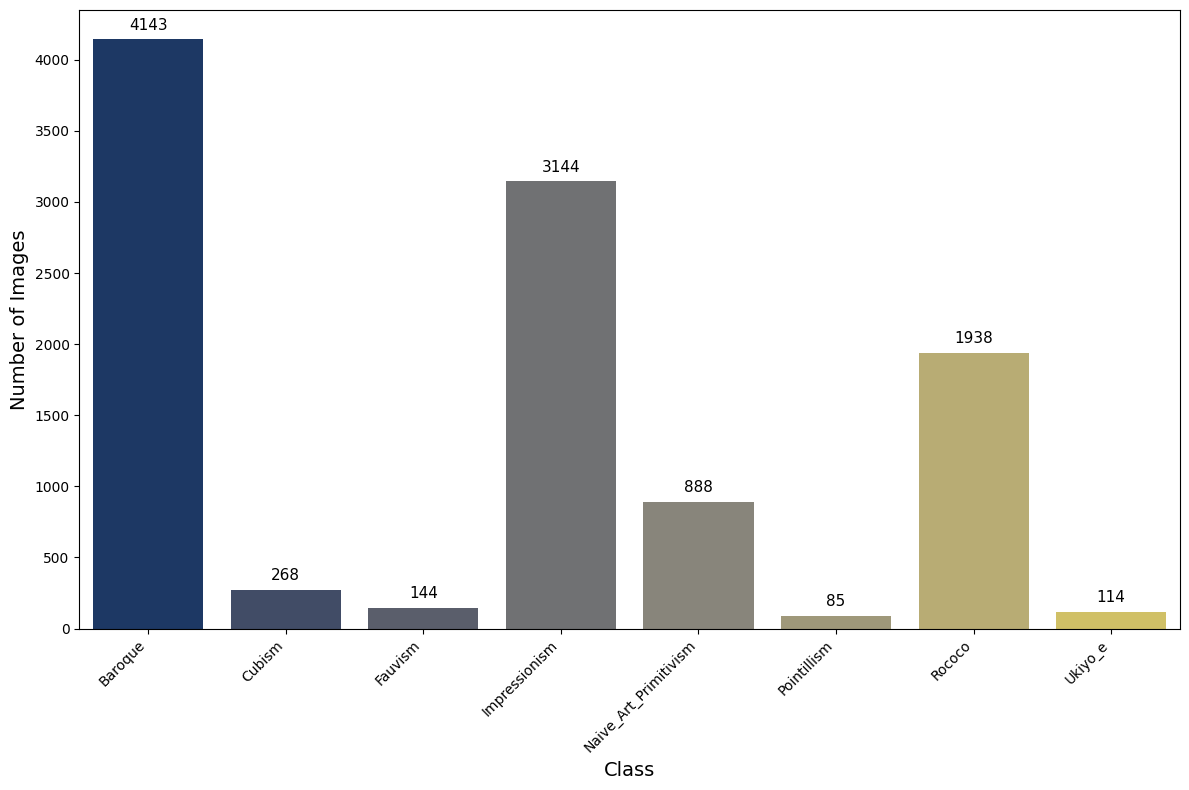

In [44]:
import os
from torchvision import datasets
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Path to your dataset
data_dir = 'faces2'  

# Load dataset
dataset = datasets.ImageFolder(root=data_dir)
class_names = ['Baroque','Cubism', 'Fauvism', 'Impressionism','Naive_Art_Primitivism','Pointillism','Rococo','Ukiyo_e']
class_counts = Counter(dataset.targets)

# Ensure class names are treated as strings (just in case they're numbers)
class_names = [str(name) for name in class_names]
counts = [class_counts[i] for i in range(len(class_names))]

# Plot
plt.figure(figsize=(12, 8))
colors = sns.color_palette("cividis", len(class_names))
bars = sns.barplot(x=class_names, y=counts, palette=colors)

# Add counts on top of bars
for bar, count in zip(bars.patches, counts):
    height = bar.get_height()
    bars.annotate(f'{count}', xy=(bar.get_x() + bar.get_width() / 2, height),
                  xytext=(0, 5), textcoords='offset points',
                  ha='center', va='bottom', fontsize=11)

plt.xlabel("Class", fontsize=14)
plt.ylabel("Number of Images", fontsize=14)
plt.xticks(rotation=45, ha='right')  # rotate if class names are long or numeric
plt.tight_layout()
plt.savefig("dist2", dpi=300, bbox_inches='tight')  # Save to file
plt.show()


In [7]:
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 8.6 MB/s eta 0:00:00


In [12]:
class ArtStyleDataset(Dataset):
  def __init__(self, root_dir, transform = None, transform_tensor = None):
     self.imgs = ImageFolder(root_dir)
     self.root_dir = root_dir
     self.transform = transform
     self.transform_tensor = transform_tensor


  def __len__(self):
        return len(self.imgs)

  def __getitem__(self, idx):
        sample, label = self.imgs[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample, label
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
data = ArtStyleDataset('faces2', transform)


In [13]:
model_name ="resnet_2_FACES_new"

class Model (torch.nn.Module):
  def __init__(self, layer_name: str = 'layer2'):
     super(Model, self).__init__()
     self.model = models.resnet18(pretrained=True)
     self.layer_name = layer_name

     self.activations = dict()

     def hook(module, input, output):
        self.activations[layer_name] = output

     self.model.get_submodule(layer_name).register_forward_hook(hook)

  def forward(self, x):
        _ = self.model(x)
        return self.activations[self.layer_name]

In [14]:
device = 'cuda'

model = Model().to(device)
dataset = dl.data_load(data)
train_data , train_labels,map_img_feature = dl.extract_features(model, dataset)
dl.save_pickle(train_data,train_labels, model_name)

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


(128,)
(227,)
----------------------------------
(128,)


/opt/conda/lib/python3.11/site-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


(227,)
----------------------------------
(128,)
(227,)
----------------------------------
(128,)
(227,)
----------------------------------
(128,)
(227,)
----------------------------------
(128,)
(227,)
----------------------------------
(128,)
(227,)
----------------------------------
(128,)
(227,)
----------------------------------
(128,)
(227,)
----------------------------------
(128,)
(227,)
----------------------------------
(128,)
(227,)
----------------------------------
(128,)
(227,)
----------------------------------
(128,)
(227,)
----------------------------------
(128,)
(227,)
----------------------------------
(128,)
(227,)
----------------------------------
(128,)
(227,)
----------------------------------
(128,)
(227,)
----------------------------------
(128,)
(227,)
----------------------------------
(128,)
(227,)
----------------------------------
(128,)
(227,)
----------------------------------
(128,)
(227,)
----------------------------------
(128,)
(227,)
-------------

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
train_data_scaled = scaler.fit_transform(train_data)

train_labels = np.array(train_labels)
train_labels = train_labels.ravel()


print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 8590, Test: 2148


In [28]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import  numpy as np
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import time
import psutil
import pandas as pd
from sklearn.metrics import  ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, roc_curve, auc, precision_recall_curve, confusion_matrix
)
class_names2 = ['Baroque','Cubism', 'Fauvism', 'Impressionism','Naive_Art_Primitivism','Pointillism','Rococo','Ukiyo_e']

def precision_recall_draw(y_true, y_score):
    from sklearn.preprocessing import label_binarize
    from sklearn.metrics import precision_recall_curve

    y_test_bin = label_binarize(y_true, classes=[i for i in range(len(class_names2))])

    plt.figure(figsize=(15, 10))
    for i, class_name in enumerate(class_names2):
        precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
        plt.plot(recall, precision, lw=2, label=f'{class_name}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Each Class')
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()


def roc_draw(y_true, y_score):
  from sklearn.preprocessing import label_binarize
  plt.figure(figsize=(15, 10))
  y_test_bin = label_binarize(y_true, classes=[i for i in range(len(class_names2))])


  for i, class_name in enumerate(class_names2):
     fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
     roc_auc = auc(fpr, tpr)
     plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.2f})')


  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic Curve')
  plt.legend(loc="best")
  plt.grid(True)
  plt.show()


def evaluate_model(y_true, y_pred, y_pred_proba):
    report_dict = classification_report(y_pred, y_true, target_names=class_names, output_dict=True)
    metrics_df2 = pd.DataFrame(report_dict).transpose()
    print(metrics_df2)
    print("-----------------------------------------------------------------------------------------------------------")

    precision_recall_draw(y_true, y_pred_proba)
    roc_draw(y_true, y_pred_proba)
    cm =confusion_matrix(y_true, y_pred, normalize = 'true')
    #cm_percent_row = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
    
    disp = ConfusionMatrixDisplay(cm*100, display_labels=class_names2)

    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(cmap="cividis", ax=ax) 
    for _, spine in ax.spines.items():
        spine.set_visible(False)  

    plt.xticks(rotation=90, ha="right")
    plt.yticks(rotation=0)
    plt.grid(False) 
    plt.title("Confusion Matrix")
    #plt.colorbar(ax.collections[0], ax=ax)  

    disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=class_names2)

    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(cmap="cividis", ax=ax) 
    for _, spine in ax.spines.items():
        spine.set_visible(False)  

    plt.xticks(rotation=90, ha="right")
    plt.yticks(rotation=0)
    plt.grid(False) 
    plt.title("Not normalized Confusion Matrix")
    plt.show()

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle

with open('X_resnet_2_FACEbbS.pickle', 'rb') as handle:
    train_data = pickle.load(handle)
with open('Y_resnet_2_FACES.pickle', 'rb') as handle:
    train_labels = pickle.load(handle)

X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
train_data_scaled = scaler.fit_transform(train_data)

train_labels = np.array(train_labels)
train_labels = train_labels.ravel()


print(f"Train: {np.shape(X_train)}, Test: {np.shape(X_test)}")
print(f"Train: {np.shape(train_data)}, Test: {np.shape(train_labels)}")

Train: (8590, 227), Test: (2148, 227)
Train: (10738, 227), Test: (10738,)


In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
train_data_scaled = scaler.fit_transform(train_data)

train_labels = np.array(train_labels)
train_labels = train_labels.ravel()


print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 8579, Test: 2145


                       precision    recall  f1-score      support
baroque                 0.888489  0.865654  0.876923   856.000000
cubism                  0.823529  0.875000  0.848485    32.000000
fauvism                 0.772727  0.850000  0.809524    20.000000
impressionism           0.885271  0.859940  0.872422   664.000000
na-ve-art-primitivism   0.733766  0.911290  0.812950   124.000000
pointillism             0.772727  0.850000  0.809524    20.000000
rococo                  0.816832  0.820896  0.818859   402.000000
ukiyo-e                 0.900000  1.000000  0.947368    27.000000
accuracy                0.859674  0.859674  0.859674     0.859674
macro avg               0.824168  0.879097  0.849507  2145.000000
weighted avg            0.862136  0.859674  0.860155  2145.000000
-----------------------------------------------------------------------------------------------------------


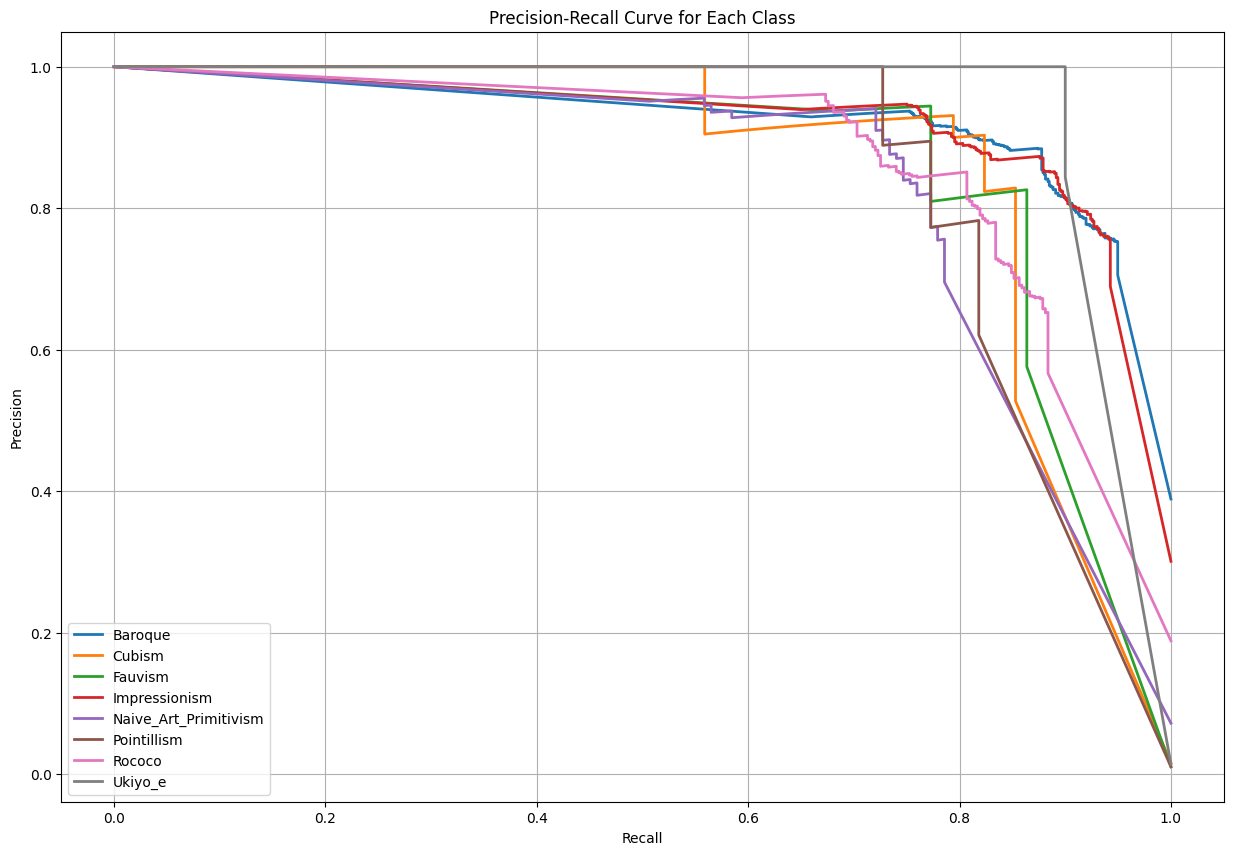

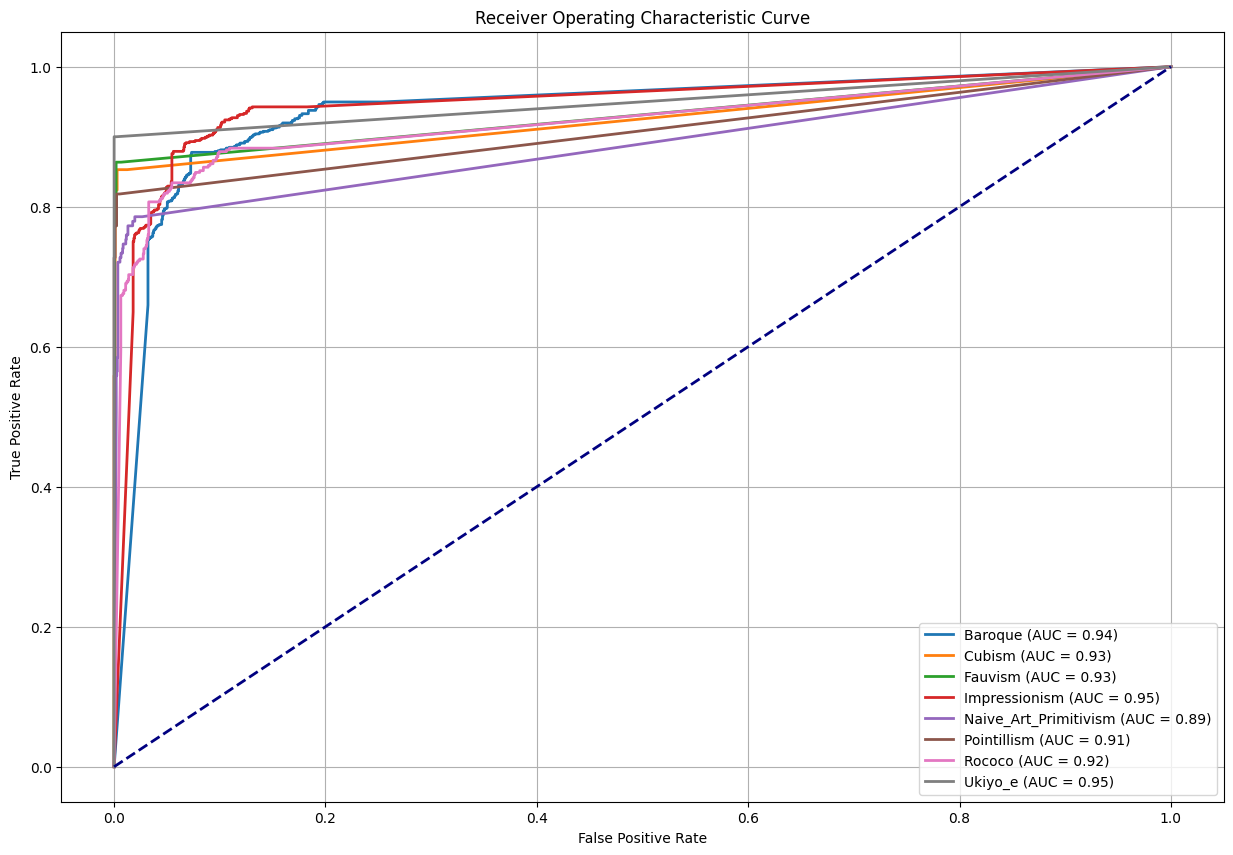

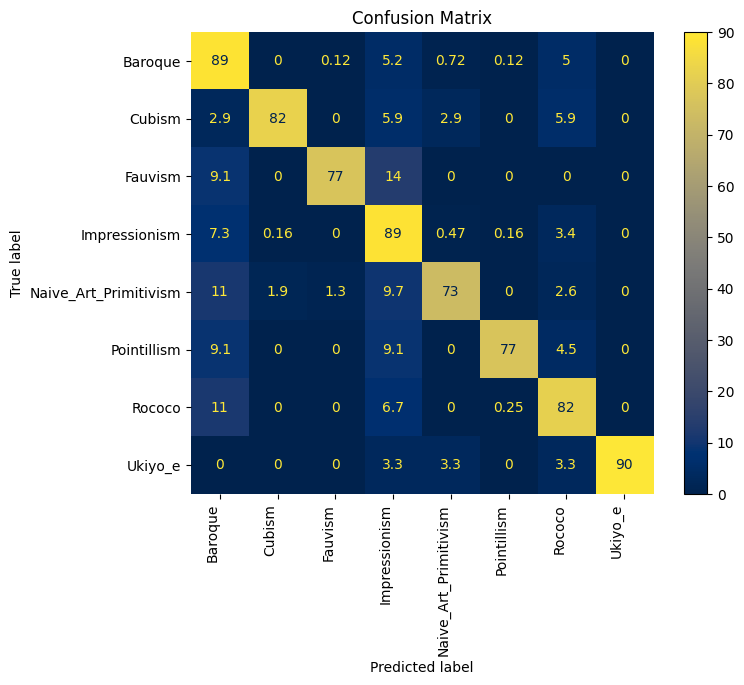

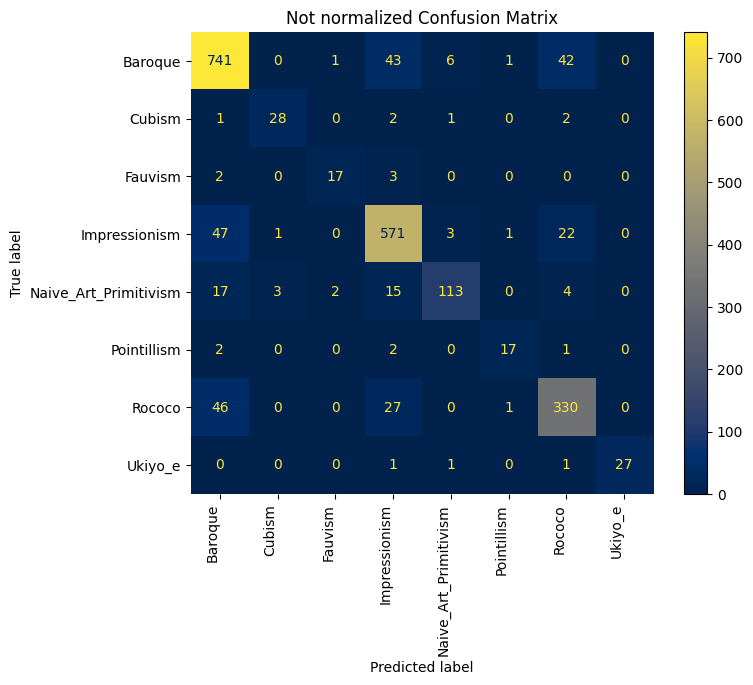

In [30]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(
    metric='manhattan',
    algorithm='auto',
    n_neighbors=3,
    weights='distance',
    leaf_size=40,
    p=1  
)

knn_model.fit(X_train_scaled, y_train)
frmodel_pred = knn_model.predict(X_test_scaled)
frmodel_pred_proba = knn_model.predict_proba(X_test_scaled)

evaluate_model(y_test,frmodel_pred,frmodel_pred_proba)

In [31]:
knn_model = KNeighborsClassifier(
    metric='manhattan',
    algorithm='auto',
    n_neighbors=3,
    weights='distance',
    leaf_size=40,
    p=1  
)
avg= e.kfold_crossvalidation(train_data, train_labels, 5,  knn_model , 1)
print(avg)

       Fold  Precision    Recall        F1  Accuracy  Train time  \
0         1   0.858074  0.857809  0.856889  0.857809    0.003448   
1         2   0.846741  0.847086  0.846349  0.847086    0.004320   
2         3   0.853317  0.850350  0.850329  0.850350    0.006068   
3         4   0.880852  0.879720  0.879349  0.879720    0.006012   
4         5   0.852357  0.852146  0.851217  0.852146    0.005881   
5   Average   0.858268  0.857422  0.856827  0.857422    0.005146   
6  1.581139   0.013251  0.013058  0.013141  0.013058    0.001195   

   Prediction time  
0         0.211904  
1         0.204667  
2         0.206279  
3         0.205492  
4         0.205621  
5         0.206792  
6         0.002914  


                       precision    recall  f1-score      support
baroque                 0.934053  0.874299  0.903188   891.000000
cubism                  0.735294  0.925926  0.819672    27.000000
fauvism                 0.818182  0.857143  0.837209    21.000000
impressionism           0.925581  0.895052  0.910061   667.000000
na-ve-art-primitivism   0.779221  0.902256  0.836237   133.000000
pointillism             0.772727  1.000000  0.871795    17.000000
rococo                  0.811881  0.906077  0.856397   362.000000
ukiyo-e                 0.866667  0.962963  0.912281    27.000000
accuracy                0.890443  0.890443  0.890443     0.890443
macro avg               0.830451  0.915464  0.868355  2145.000000
weighted avg            0.895437  0.890443  0.891446  2145.000000
-----------------------------------------------------------------------------------------------------------


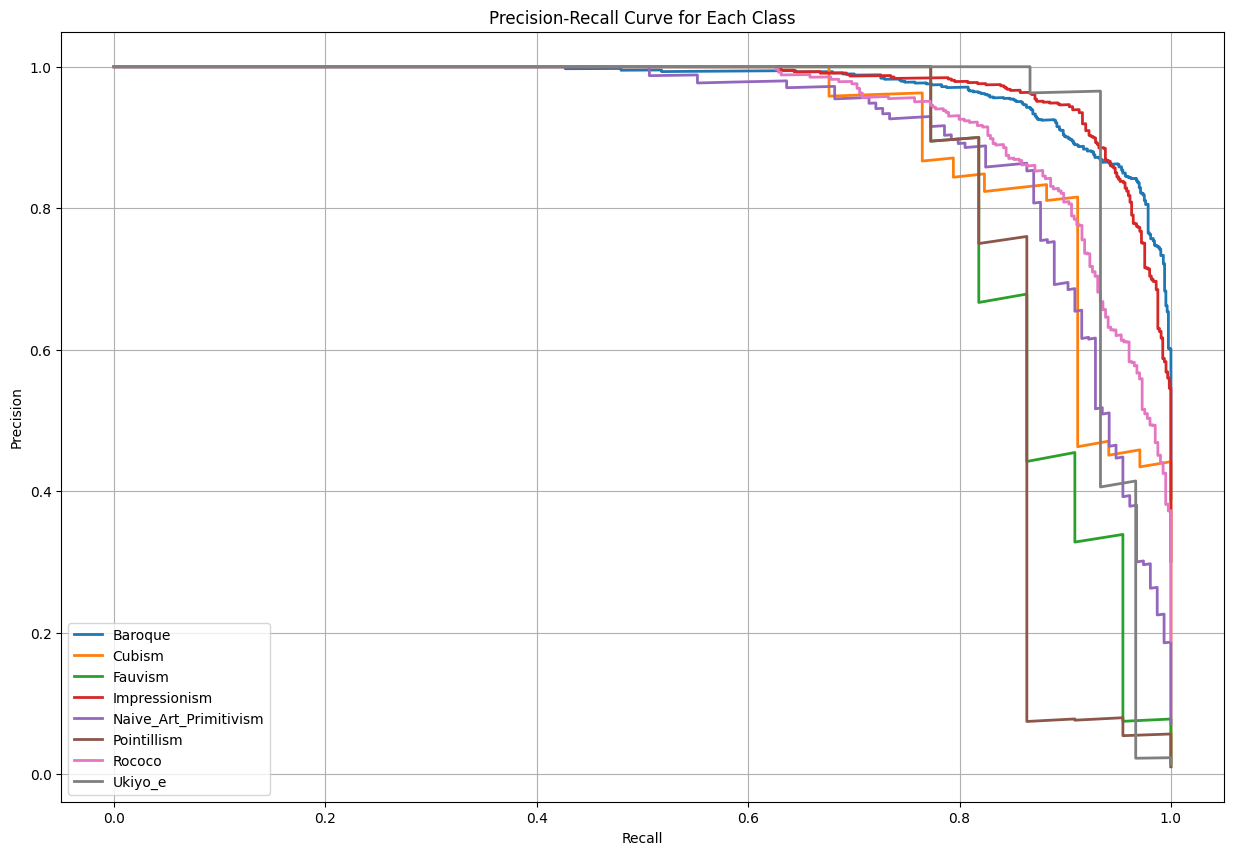

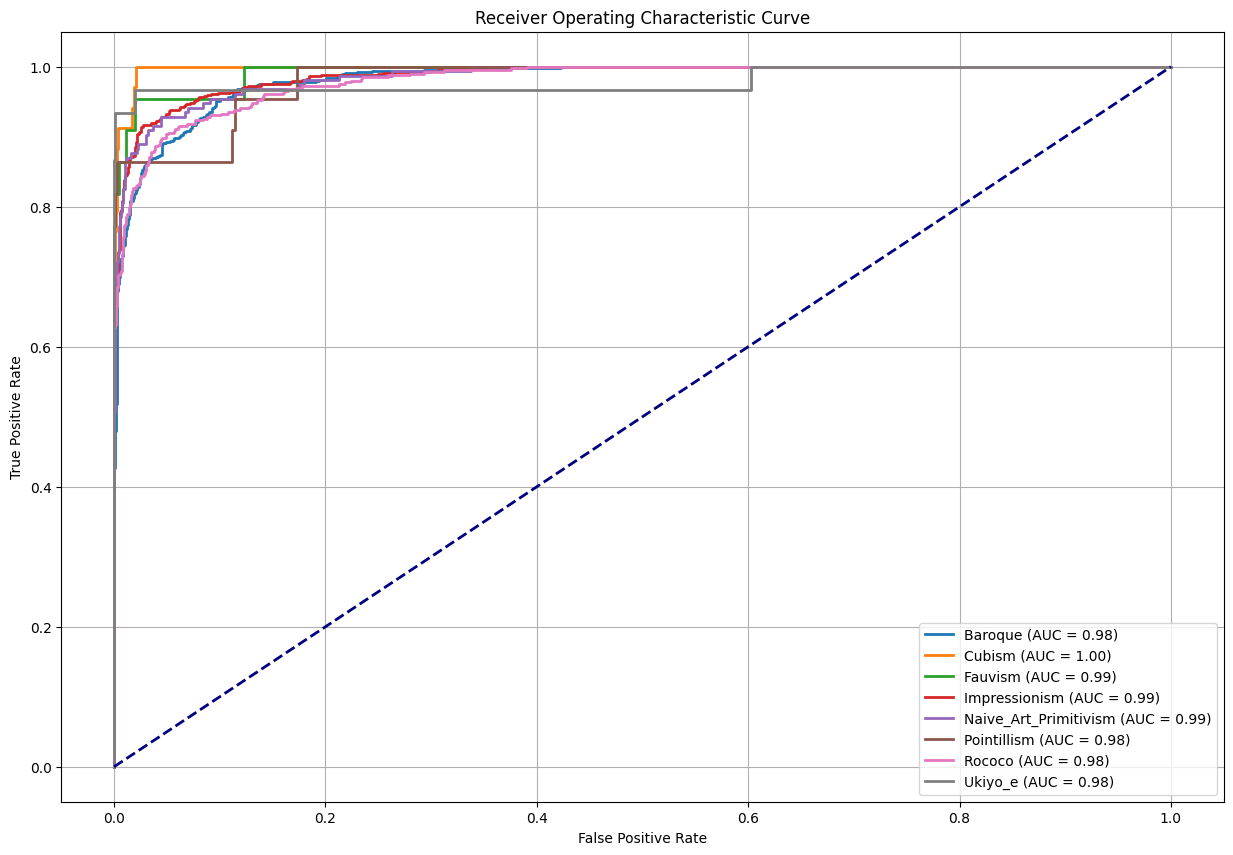

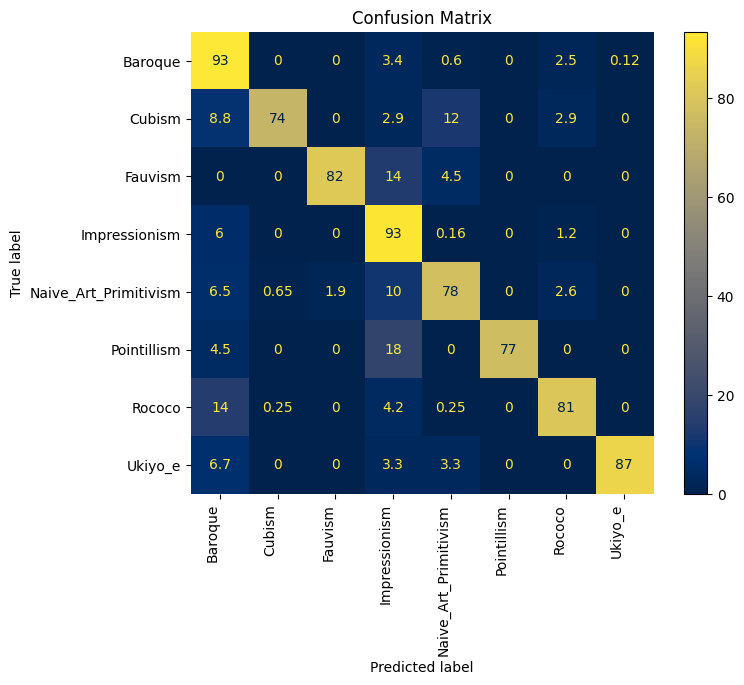

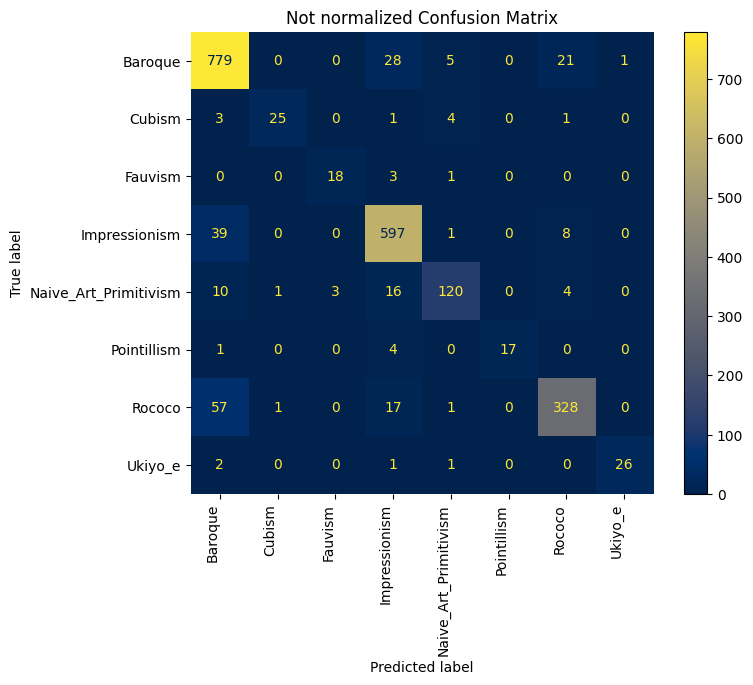

In [32]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    n_estimators=700,
    max_depth=6,
    learning_rate=0.06880464674379164,
    subsample=0.5717805315996993,
    colsample_bytree=0.72163837917479,
    gamma= 0.739211143509742,
    reg_lambda=0.31918802481802655,
    reg_alpha=0.5515715243593446,
    objective="multi:softmax",  
    eval_metric="mlogloss",
    tree_method="hist", 
)
xgb_model.fit(X_train_scaled, y_train)
frmodel_pred = xgb_model.predict(X_test_scaled)
frmodel_pred_proba = xgb_model.predict_proba(X_test_scaled)

evaluate_model(y_test,frmodel_pred,frmodel_pred_proba)


In [33]:
xgb_model = xgb.XGBClassifier(
    n_estimators=700,
    max_depth=6,
    learning_rate=0.06880464674379164,
    subsample=0.5717805315996993,
    colsample_bytree=0.72163837917479,
    gamma= 0.739211143509742,
    reg_lambda=0.31918802481802655,
    reg_alpha=0.5515715243593446,
    objective="multi:softmax",  
    eval_metric="mlogloss",
    tree_method="hist", 
)
avg= e.kfold_crossvalidation(train_data, train_labels, 5,  xgb_model , 1)
print(avg)

       Fold  Precision    Recall        F1  Accuracy  Train time  \
0         1   0.891279  0.889977  0.888308  0.889977   26.823722   
1         2   0.891444  0.888578  0.887236  0.888578   27.842491   
2         3   0.883276  0.880653  0.879422  0.880653   26.070243   
3         4   0.904484  0.902098  0.901042  0.902098   27.265210   
4         5   0.892822  0.892724  0.890977  0.892724   28.198833   
5   Average   0.892661  0.890806  0.889397  0.890806   27.240100   
6  1.581139   0.007604  0.007745  0.007802  0.007745    0.840329   

   Prediction time  
0         0.013198  
1         0.013951  
2         0.009644  
3         0.010761  
4         0.010692  
5         0.011649  
6         0.001832  


                       precision    recall  f1-score      support
baroque                 0.950839  0.830366  0.886529   955.000000
cubism                  0.764706  1.000000  0.866667    26.000000
fauvism                 0.818182  0.947368  0.878049    19.000000
impressionism           0.917829  0.875740  0.896291   676.000000
na-ve-art-primitivism   0.688312  0.921739  0.788104   115.000000
pointillism             0.772727  1.000000  0.871795    17.000000
rococo                  0.754950  0.977564  0.851955   312.000000
ukiyo-e                 0.833333  1.000000  0.909091    25.000000
accuracy                0.877389  0.877389  0.877389     0.877389
macro avg               0.812610  0.944097  0.868560  2145.000000
weighted avg            0.891656  0.877389  0.879130  2145.000000
-----------------------------------------------------------------------------------------------------------


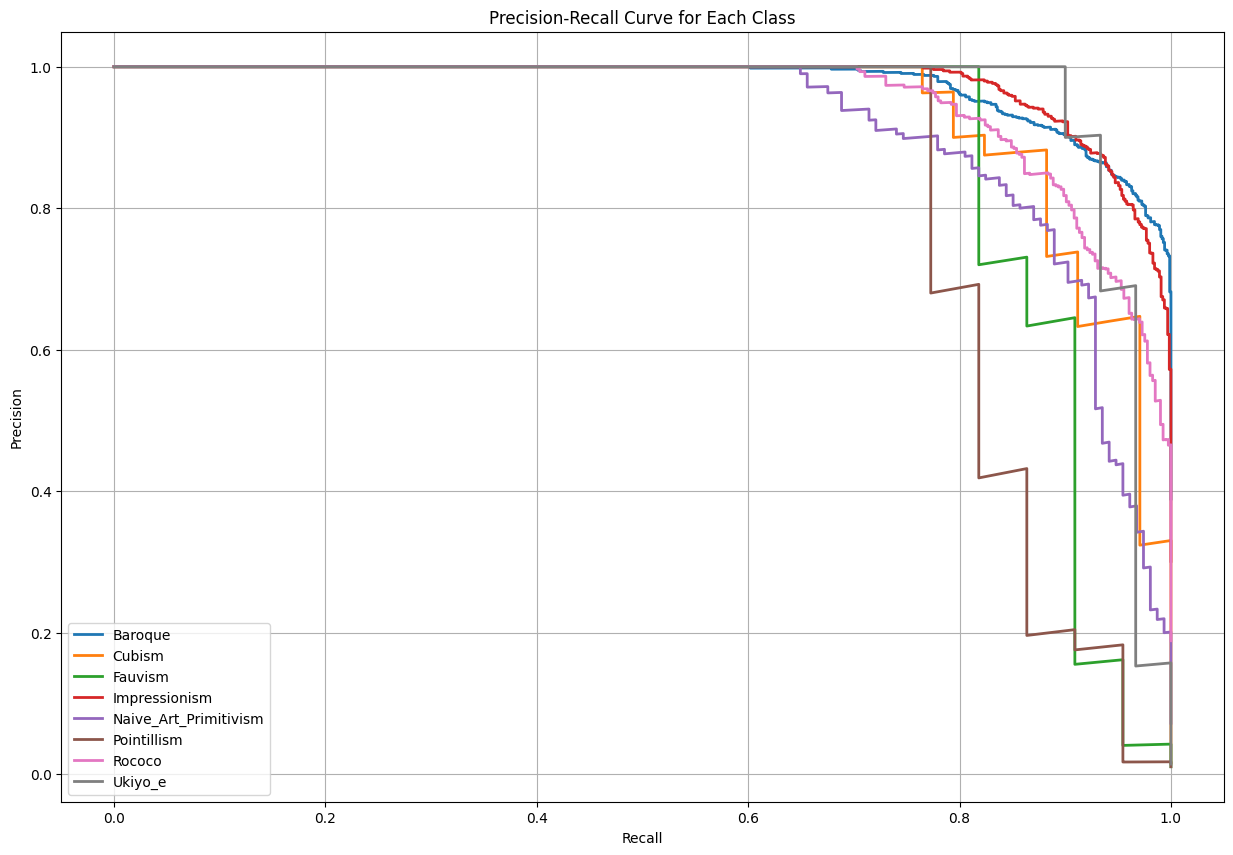

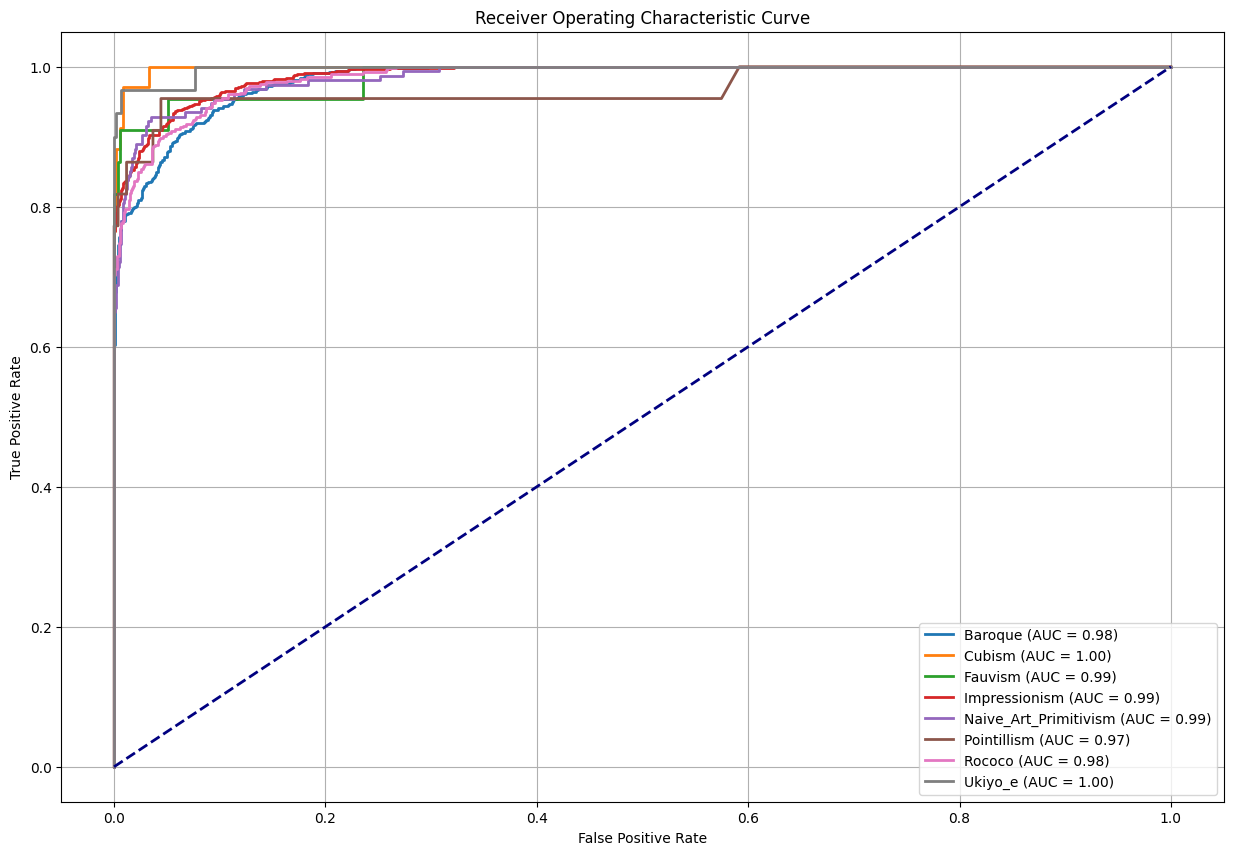

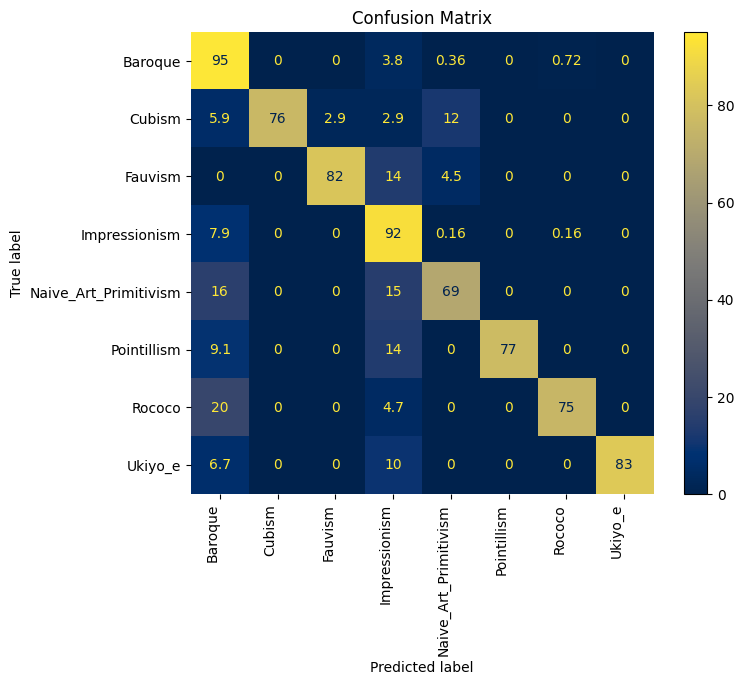

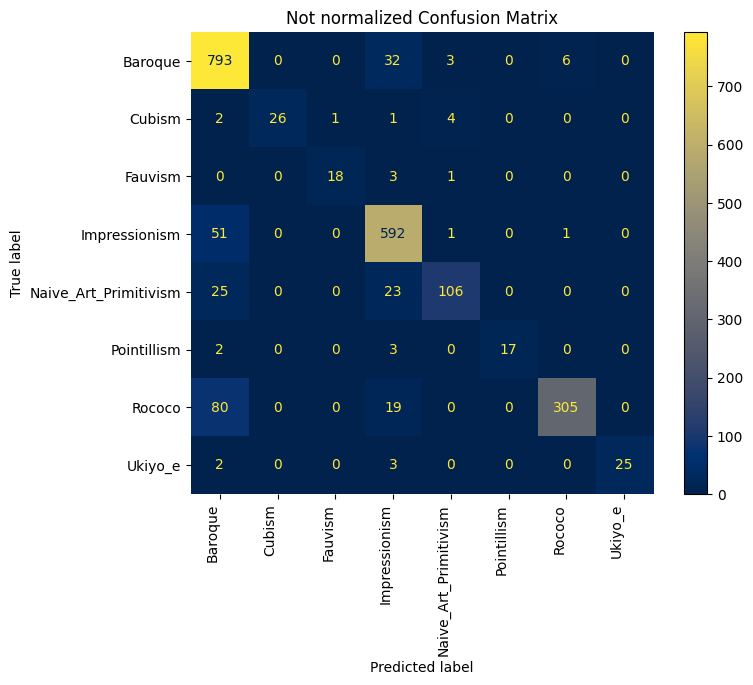

In [34]:
from sklearn.ensemble import RandomForestClassifier

rfmodel = RandomForestClassifier(n_estimators = 1100, 
                                 max_depth = 31, 
                                 min_samples_split =  8,
                                 min_samples_leaf = 2, 
                                 max_features = 'sqrt', 
                                 bootstrap = False,  
                                 criterion = 'gini')
rfmodel.fit(X_train_scaled, y_train)
frmodel_pred = rfmodel.predict(X_test_scaled)
frmodel_pred_proba = rfmodel.predict_proba(X_test_scaled)

evaluate_model(y_test,frmodel_pred,frmodel_pred_proba)

In [35]:
rfmodel = RandomForestClassifier(n_estimators = 1100, 
                                 max_depth = 31, 
                                 min_samples_split =  8,
                                 min_samples_leaf = 2, 
                                 max_features = 'sqrt', 
                                 bootstrap = False,  
                                 criterion = 'gini')
avg= e.kfold_crossvalidation(train_data, train_labels, 5,  rfmodel , 1)
print(avg)

       Fold  Precision    Recall        F1  Accuracy  Train time  \
0         1   0.882198  0.872727  0.870555  0.872727  142.995942   
1         2   0.877799  0.868065  0.865729  0.868065  141.367260   
2         3   0.875216  0.864802  0.863454  0.864802  140.991647   
3         4   0.901737  0.893240  0.891883  0.893240  142.368759   
4         5   0.888244  0.879198  0.876874  0.879198  141.565031   
5   Average   0.885039  0.875606  0.873699  0.875606  141.857728   
6  1.581139   0.010560  0.011244  0.011392  0.011244    0.811328   

   Prediction time  
0         0.337604  
1         0.344399  
2         0.369528  
3         0.331606  
4         0.343622  
5         0.345352  
6         0.014469  


In [36]:
model_name ="resnet_3_FACES_new"

class Model (torch.nn.Module):
  def __init__(self, layer_name: str = 'layer3'):
     super(Model, self).__init__()
     self.model = models.resnet18(pretrained=True)
     self.layer_name = layer_name

     self.activations = dict()

     def hook(module, input, output):
        self.activations[layer_name] = output

     self.model.get_submodule(layer_name).register_forward_hook(hook)

  def forward(self, x):
        _ = self.model(x)
        return self.activations[self.layer_name]

In [37]:
device = 'cuda'

model = Model().to(device)
dataset = dl.data_load(data)
train_data , train_labels,map_img_feature = dl.extract_features(model, dataset)
dl.save_pickle(train_data,train_labels, model_name)

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


(256,)
(355,)
----------------------------------
(256,)
(355,)
----------------------------------
(256,)
(355,)
----------------------------------
(256,)


/opt/conda/lib/python3.11/site-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


(355,)
----------------------------------
(256,)
(355,)
----------------------------------
(256,)
(355,)
----------------------------------
(256,)
(355,)
----------------------------------
(256,)
(355,)
----------------------------------
(256,)
(355,)
----------------------------------
(256,)
(355,)
----------------------------------
(256,)
(355,)
----------------------------------
(256,)
(355,)
----------------------------------
(256,)
(355,)
----------------------------------
(256,)
(355,)
----------------------------------
(256,)
(355,)
----------------------------------
(256,)
(355,)
----------------------------------
(256,)
(355,)
----------------------------------
(256,)
(355,)
----------------------------------
(256,)
(355,)
----------------------------------
(256,)
(355,)
----------------------------------
(256,)
(355,)
----------------------------------
(256,)
(355,)
----------------------------------
(256,)
(355,)
----------------------------------
(256,)
(355,)
-------------

                       precision    recall  f1-score     support
baroque                 0.892086  0.842582  0.866628   883.00000
cubism                  0.764706  0.896552  0.825397    29.00000
fauvism                 0.863636  0.791667  0.826087    24.00000
impressionism           0.885271  0.879815  0.882535   649.00000
na-ve-art-primitivism   0.779221  0.869565  0.821918   138.00000
pointillism             0.772727  0.944444  0.850000    18.00000
rococo                  0.797030  0.856383  0.825641   376.00000
ukiyo-e                 0.866667  0.928571  0.896552    28.00000
accuracy                0.860140  0.860140  0.860140     0.86014
macro avg               0.827668  0.876197  0.849345  2145.00000
weighted avg            0.862727  0.860140  0.860620  2145.00000
-----------------------------------------------------------------------------------------------------------


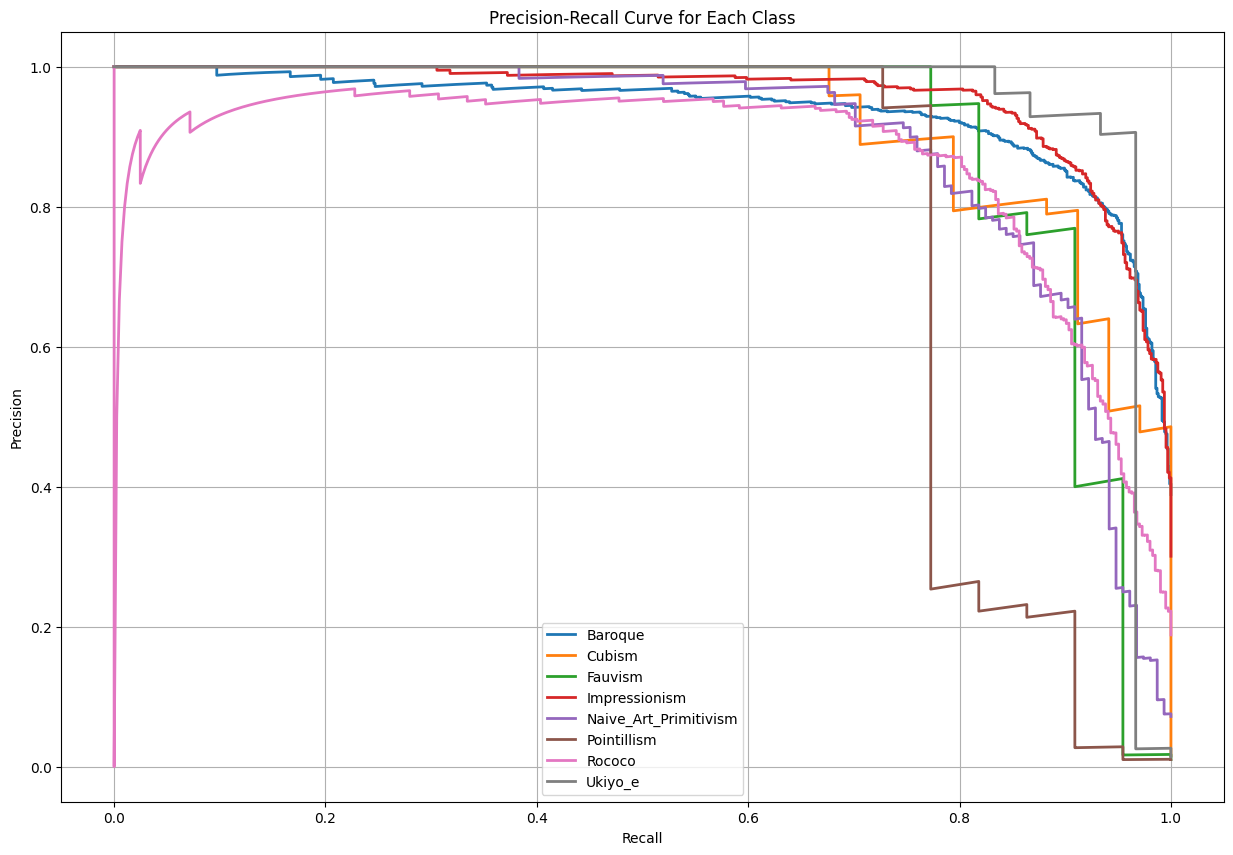

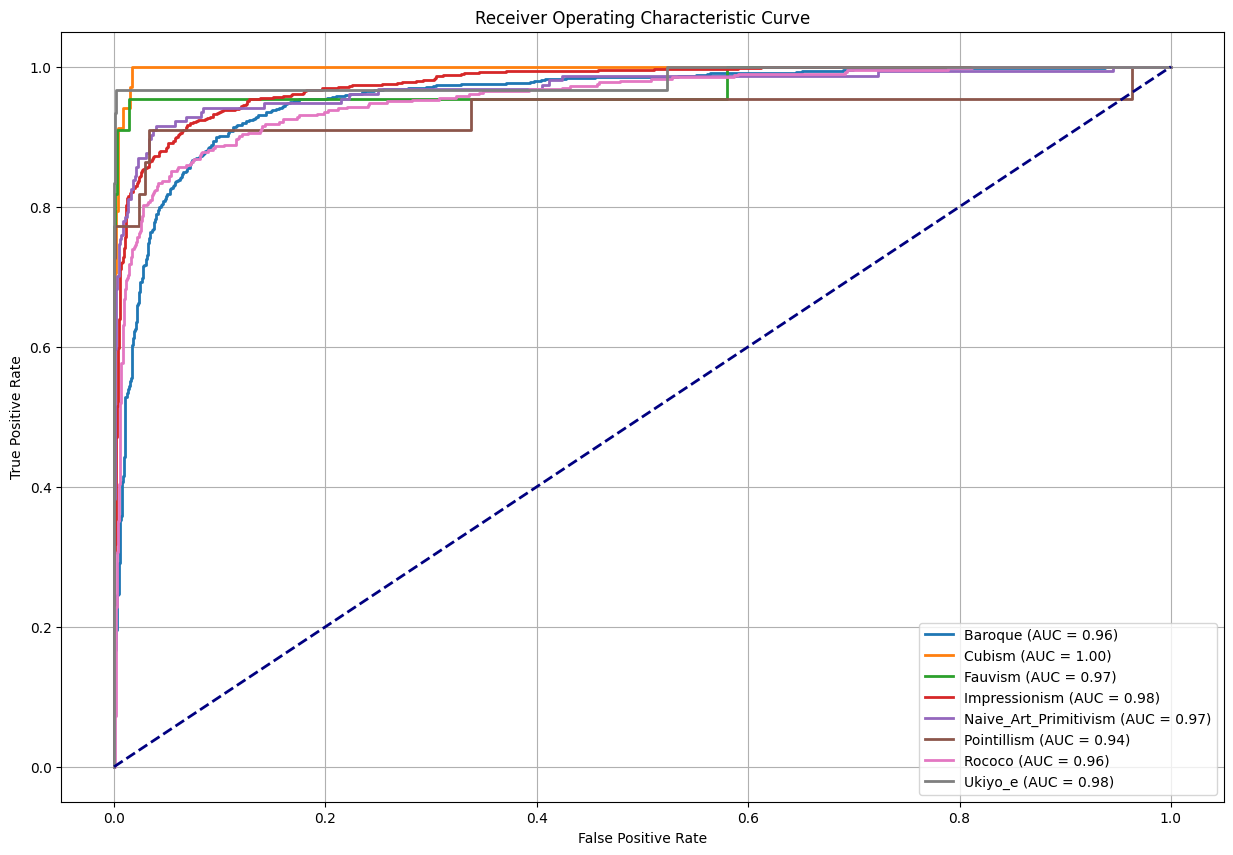

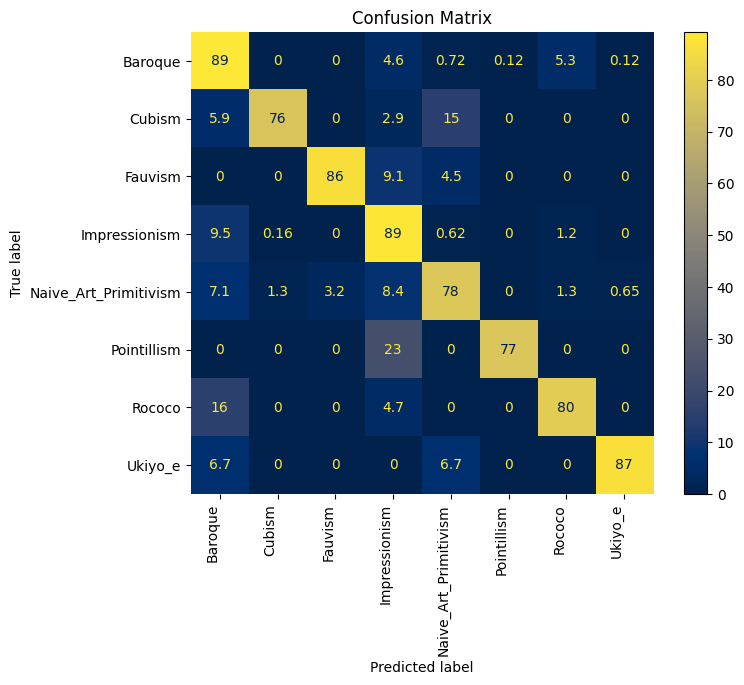

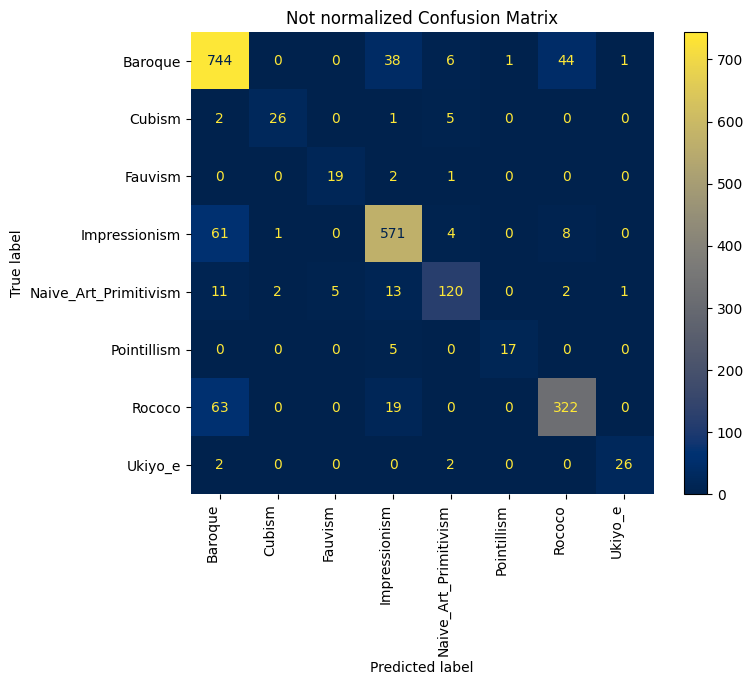

In [40]:
from sklearn.svm import SVC

svc_model = SVC(
    kernel='poly', 
    C=60.38139932266792, 
    gamma=3.011984770287577, 
    degree=2, 
    random_state=42,
    probability = True
)

svc_model.fit(X_train_scaled, y_train)
frmodel_pred = svc_model.predict(X_test_scaled)
frmodel_pred_proba = svc_model.predict_proba(X_test_scaled)

evaluate_model(y_test,frmodel_pred,frmodel_pred_proba)

In [39]:
avg= e.kfold_crossvalidation(train_data, train_labels, 5,  svc_model , 1)
print(avg)

/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

       Fold  Precision    Recall        F1  Accuracy  Train time  \
0         1   0.875877  0.871329  0.870398  0.871329   58.640395   
1         2   0.887083  0.882051  0.880973  0.882051   58.396652   
2         3   0.892300  0.888578  0.888480  0.888578   59.967259   
3         4   0.882107  0.878788  0.878354  0.878788   58.840446   
4         5   0.885495  0.880597  0.879657  0.880597   59.653196   
5   Average   0.884573  0.880269  0.879572  0.880269   59.099590   
6  1.581139   0.006094  0.006214  0.006461  0.006214    0.676658   

   Prediction time  
0         1.141883  
1         1.074344  
2         1.100914  
3         1.149065  
4         1.097404  
5         1.112722  
6         0.031695  


In [41]:
model_name ="densenet_tr3_FACES_NEW"
from torch.utils.data import WeightedRandomSampler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import time
import os
import copy
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
import cv2
import numpy as np
import imageio as io
from PIL import Image
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

import torchmetrics
import pytorch_lightning as pl

import data_loader as dl
import experiments as e


!python --version
!nvcc --version
!pip install nvcc4jupyter
%load_ext nvcc4jupyter
class_names2 = ['Baroque','Cubism', 'Fauvism', 'Impressionism','Naive_Art_Primitivism','Pointillism','Rococo','Ukiyo_e']

num_classes = 8


class Model (torch.nn.Module):
  # def __init__(self, layer_name: str = 'features.4'): layer1
  def __init__(self, layer_name: str = 'features.transition3'):
     super(Model, self).__init__()
     self.model = models.densenet121(pretrained=True)
     self.layer_name = layer_name

     self.activations = dict()

     def hook(module, input, output):
        self.activations[layer_name] = output

     self.model.get_submodule(layer_name).register_forward_hook(hook)

  def forward(self, x):
        # return self.model(x)
        # pass
        _ = self.model(x)

        return self.activations[self.layer_name]

model = Model().to(device)
dataset = dl.data_load(data)
train_data , train_labels,map_img_feature = dl.extract_features(model, dataset)
dl.save_pickle(train_data,train_labels, model_name)

Python 3.11.6
/usr/bin/sh: line 1: nvcc: command not found
The nvcc4jupyter extension is already loaded. To reload it, use:
  %reload_ext nvcc4jupyter


/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /home//.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 106MB/s] 


(512,)
(611,)
----------------------------------
(512,)
(611,)
----------------------------------
(512,)


/opt/conda/lib/python3.11/site-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


(611,)
----------------------------------
(512,)
(611,)
----------------------------------
(512,)
(611,)
----------------------------------
(512,)
(611,)
----------------------------------
(512,)
(611,)
----------------------------------
(512,)
(611,)
----------------------------------
(512,)
(611,)
----------------------------------
(512,)
(611,)
----------------------------------
(512,)
(611,)
----------------------------------
(512,)
(611,)
----------------------------------
(512,)
(611,)
----------------------------------
(512,)
(611,)
----------------------------------
(512,)
(611,)
----------------------------------
(512,)
(611,)
----------------------------------
(512,)
(611,)
----------------------------------
(512,)
(611,)
----------------------------------
(512,)
(611,)
----------------------------------
(512,)
(611,)
----------------------------------
(512,)
(611,)
----------------------------------
(512,)
(611,)
----------------------------------
(512,)
(611,)
-------------

In [5]:
from torch.utils.data import WeightedRandomSampler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import time
import os
import copy
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
import cv2
import numpy as np
import imageio as io
from PIL import Image
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

import torchmetrics
import pytorch_lightning as pl

import data_loader as dl
import experiments as e

num_classes = 10

!python --version
!nvcc --version
!pip install nvcc4jupyter
%load_ext nvcc4jupyter
class_names2 = ['Baroque','Cubism', 'Fauvism', 'Impressionism','Naive_Art_Primitivism','Pointillism','Rococo','Ukiyo_e']


Python 3.11.6
/usr/bin/sh: line 1: nvcc: command not found
Source files will be saved in "/tmp/tmp8csldjeh".


                       precision    recall  f1-score      support
baroque                 0.864508  0.862440  0.863473   836.000000
cubism                  0.764706  0.634146  0.693333    41.000000
fauvism                 0.818182  0.620690  0.705882    29.000000
impressionism           0.879070  0.859091  0.868966   660.000000
na-ve-art-primitivism   0.714286  0.769231  0.740741   143.000000
pointillism             0.818182  1.000000  0.900000    18.000000
rococo                  0.794554  0.825193  0.809584   389.000000
ukiyo-e                 0.933333  0.965517  0.949153    29.000000
accuracy                0.843357  0.843357  0.843357     0.843357
macro avg               0.823353  0.817038  0.816391  2145.000000
weighted avg            0.844295  0.843357  0.843290  2145.000000
-----------------------------------------------------------------------------------------------------------


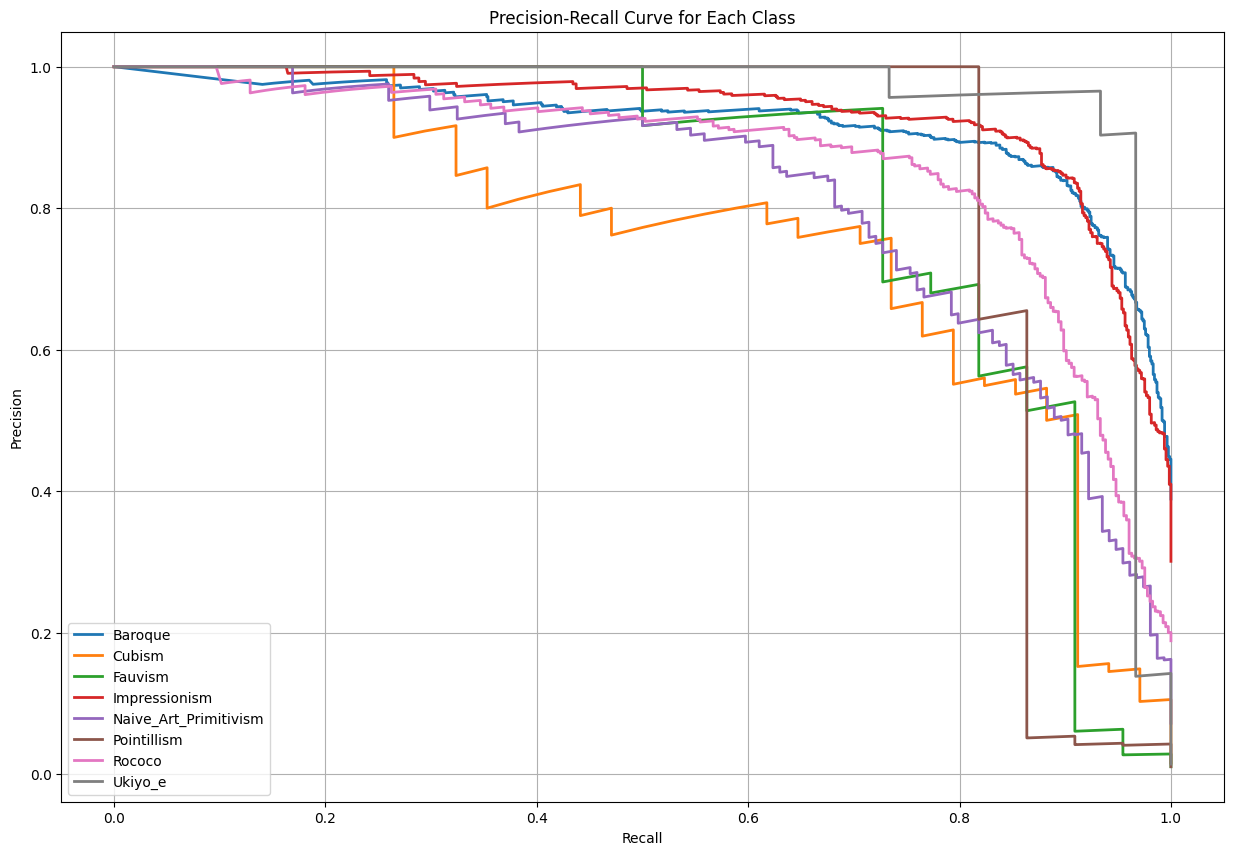

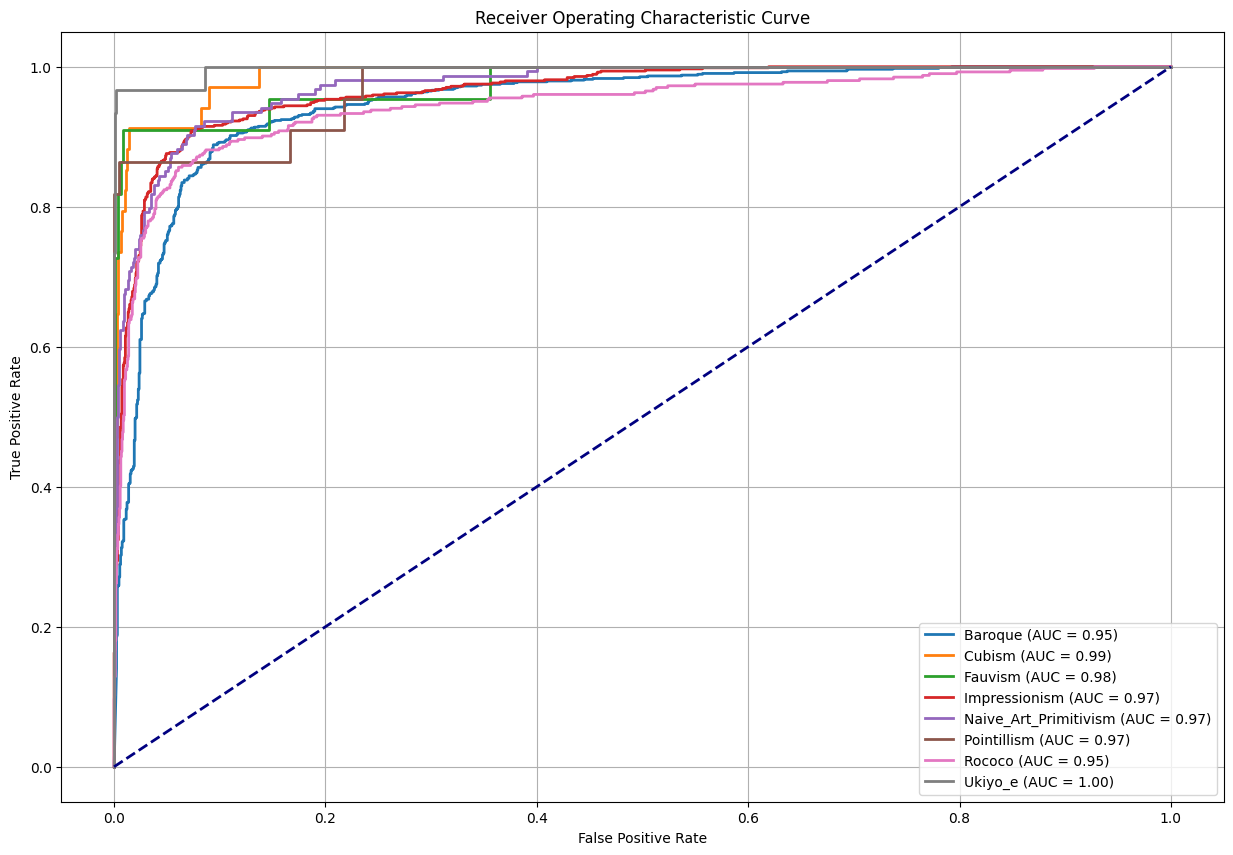

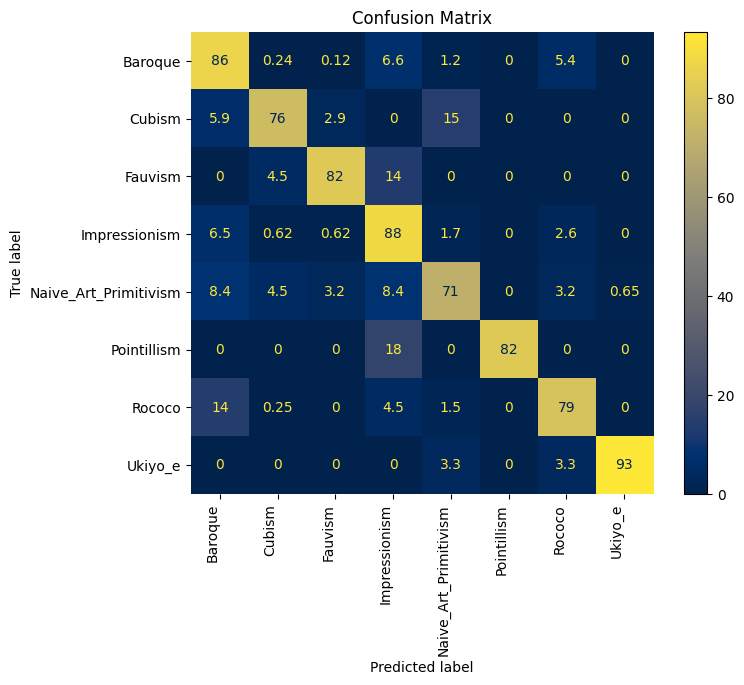

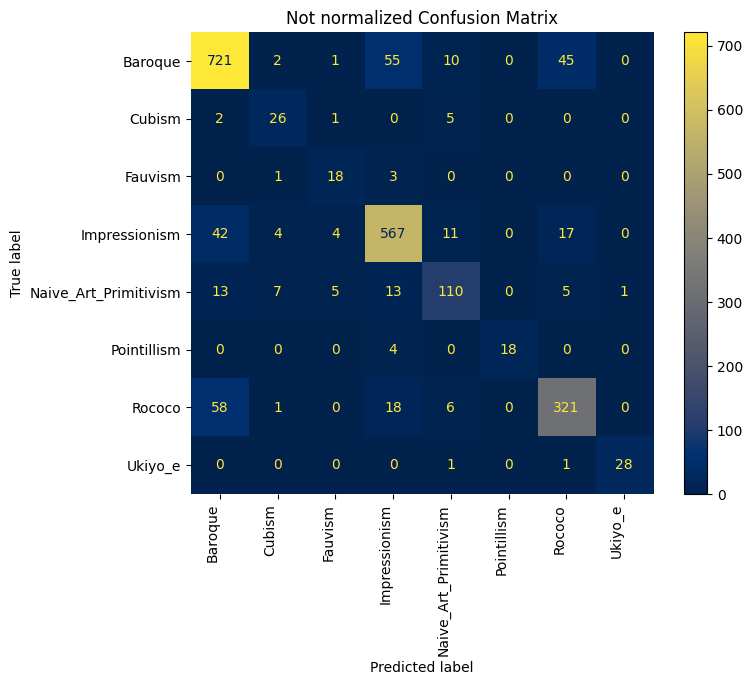

In [42]:
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(
    hidden_layer_sizes=(460, 140, 113),  
    solver='lbfgs',
    learning_rate_init=0.0003442691569297126,
    alpha= 5.2073160459223636e-06,  
    batch_size=32,  
    activation='relu',  
    max_iter=451,  
    random_state=42,
    early_stopping=True  
)

mlp_model.fit(X_train_scaled, y_train)
frmodel_pred = mlp_model.predict(X_test_scaled)
frmodel_pred_proba = mlp_model.predict_proba(X_test_scaled)

evaluate_model(y_test,frmodel_pred,frmodel_pred_proba)

In [43]:
mlp_model = MLPClassifier(
    hidden_layer_sizes=(460, 140, 113),  
    solver='lbfgs',
    learning_rate_init=0.0003442691569297126,
    alpha= 5.2073160459223636e-06,  
    batch_size=32,  
    activation='relu',  
    max_iter=451,  
    random_state=42,
    early_stopping=True  
)

avg= e.kfold_crossvalidation(train_data, train_labels, 5,  mlp_model , 1)
print(avg)
print("....")

/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed w

       Fold  Precision    Recall        F1  Accuracy  Train time  \
0         1   0.877752  0.878322  0.877529  0.878322   10.279871   
1         2   0.850222  0.850350  0.850000  0.850350   10.222222   
2         3   0.861433  0.861538  0.861241  0.861538    9.693034   
3         4   0.859821  0.861072  0.859924  0.861072    9.771029   
4         5   0.871181  0.871269  0.870922  0.871269   10.369269   
5   Average   0.864082  0.864510  0.863923  0.864510   10.067085   
6  1.581139   0.010660  0.010696  0.010620  0.010696    0.311538   

   Prediction time  
0         0.012523  
1         0.023509  
2         0.008157  
3         0.016230  
4         0.007348  
5         0.013553  
6         0.006614  
....
